# Chapter 4 - Time Series

### Stationary

A TS is said to be stationary if its statistical properties such as mean, variance remain constant over time.

    • constant mean   
    • constant variance
    • an autocovariance that does not depend on time.

What is making a TS non-stationary? There are 2 major reasons behind non-stationaruty of a TS:

    • Trend – varying mean over time. For eg, in this case we saw that on average, the number of passengers was growing over time.
    • Seasonality – variations at specific time-frames. eg people might have a tendency to buy cars in a particular month because of pay increment or festivals.

In [4]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

### Extraction

In [6]:
# Read the text file into a pandas DataFrame
df = pd.read_csv('data/multiTimeline.txt', delimiter=',')

# Show the first few rows of the DataFrame
df.head()

,Month,diet: (Worldwide),gym: (Worldwide),finance: (Worldwide)
0,2004-01,100,31,48
1,2004-02,75,26,49
2,2004-03,67,24,47
3,2004-04,70,22,48
4,2004-05,72,22,43


In [7]:
# Rename columns
df.columns = ['month', 'diet', 'gym', 'finance']

df.head()

,month,diet,gym,finance
0,2004-01,100,31,48
1,2004-02,75,26,49
2,2004-03,67,24,47
3,2004-04,70,22,48
4,2004-05,72,22,43


In [8]:
df.month = pd.to_datetime(df.month)  # Convert the 'month' column to datetime format
df.set_index('month', inplace=True)  # Set 'month' as the DataFrame index

df.head() 

,diet,gym,finance
month,,,
2004-01-01,100,31,48
2004-02-01,75,26,49
2004-03-01,67,24,47
2004-04-01,70,22,48
2004-05-01,72,22,43


### Exploratory Data Analysis (EDA)

In [10]:
# Describe
df.describe()

,diet,gym,finance
count,168.000000,168.000000,168.000000
mean,49.642857,34.690476,47.148810
std,8.033080,8.134316,4.972547
min,34.000000,22.000000,38.000000
25%,44.000000,28.000000,44.000000
50%,48.500000,32.500000,46.000000
75%,53.000000,41.000000,50.000000
max,100.000000,58.000000,73.000000


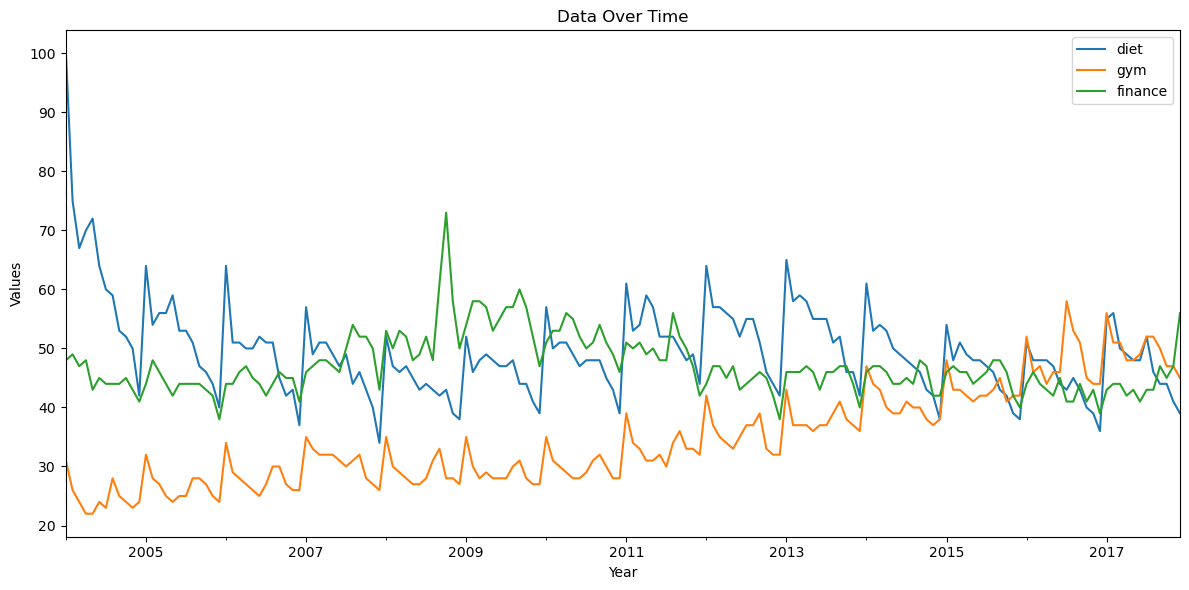

In [11]:
# Create a figure and axis with a specific size
fig, ax = plt.subplots(figsize=(12, 6))  # Width: 12 inches, Height: 6 inches

# Plot all columns in the DataFrame
df.plot(ax=ax)

# Set labels and title
plt.xlabel('Year')
plt.ylabel('Values')
plt.title('Data Over Time')

# Place the legend in the best location
plt.legend(loc='best')

# Adjust the plot to fit within the figure area
plt.tight_layout()

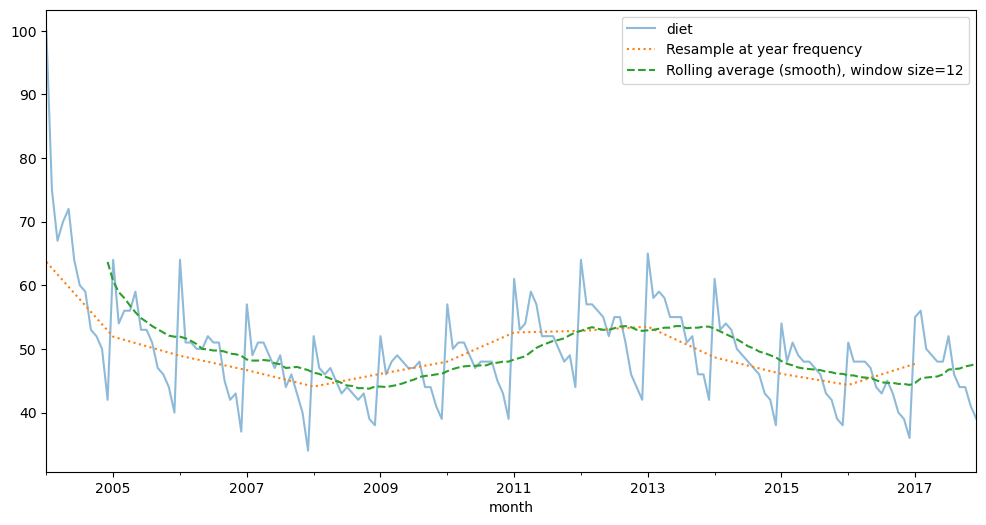

In [12]:
diet = df['diet']                            # Select the 'diet' column from the DataFrame
diet_resamp_yr = diet.resample('YE').mean()  # Resample the 'diet' data at year-end frequency and calculate the mean
diet_roll_yr = diet.rolling(12).mean()       # Calculate the rolling average with a window size of 12 months


fig, ax = plt.subplots(figsize=(12, 6))      # Create a figure and axis with a specific size

# Plot the 'diet' data 
ax = diet.plot(alpha=0.5, style='-', ax=ax)                                             # Store axis (ax) for later plotting
diet_resamp_yr.plot(style=':', label='Resample at year frequency', ax=ax)               # Plot the yearly resampled data
diet_roll_yr.plot(style='--', label='Rolling average (smooth), window size=12', ax=ax)  # Plot the rolling average 
ax.legend();                                                                            # Add a legend to the plot

#### Rolling average (smoothing) with Numpy

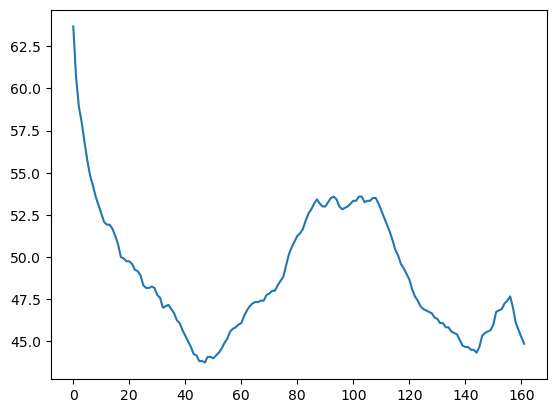

In [14]:
x = np.asarray(df[['diet']])  # Convert the 'diet' column from DataFrame to a NumPy array
win = 12                      # Define the window size for the rolling average
win_half = int(win / 2)       # Calculate half the window size for centering the rolling window
diet_smooth = np.array([x[(idx-win_half):(idx+win_half)].mean() for idx in np.arange(win_half, len(x))])  # Compute the rolling average manually
plt.plot(diet_smooth)                                                                                     # Plot the smoothed 'diet' data

#### Trends Plot Diet and Gym
Build a new DataFrame which is the concatenation diet and gym smoothed data

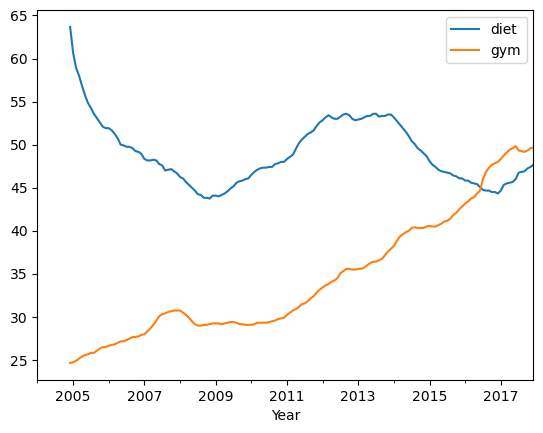

In [16]:
gym = df['gym']     # Extract the 'gym' column from the DataFrame

# Compute 12-month rolling averages for both 'diet' and 'gym', and concatenate them
df_avg = pd.concat([diet.rolling(12).mean(), gym.rolling(12).mean()], axis=1)  

df_avg.plot()       # Plot the rolling averages
plt.xlabel('Year'); # Label the x-axis;

#### Detrending

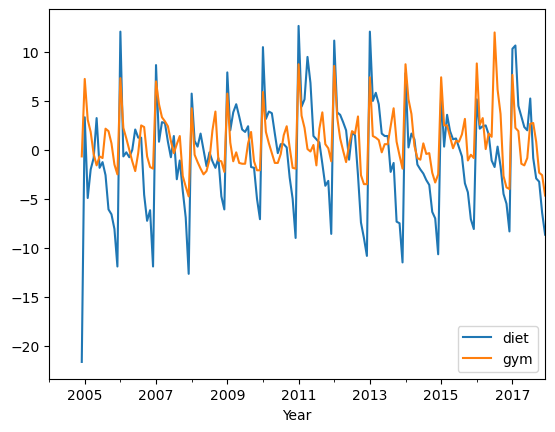

In [18]:
df_dtrend = df[["diet", "gym"]] - df_avg
df_dtrend.plot()
plt.xlabel('Year');

## First-order differencing: Seasonal Patterns

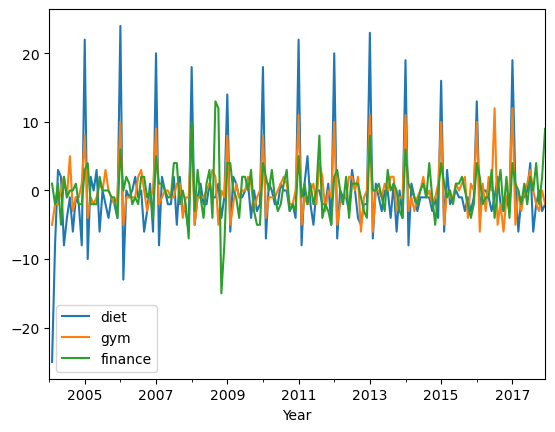

In [20]:
# diff = original - shiftted data
# (exclude first term for some implementation details)
assert np.all((diet.diff() == diet - diet.shift())[1:])
df.diff().plot()
plt.xlabel('Year');

## Periodicity and Correlation

             diet       gym   finance
diet     1.000000 -0.100764 -0.034639
gym     -0.100764  1.000000 -0.284279
finance -0.034639 -0.284279  1.000000


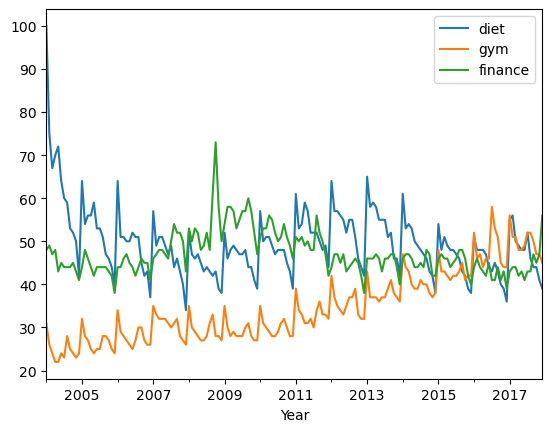

In [22]:
df.plot()
plt.xlabel('Year');
print(df.corr())

In [23]:
df.corr()

,diet,gym,finance
diet,1.000000,-0.100764,-0.034639
gym,-0.100764,1.000000,-0.284279
finance,-0.034639,-0.284279,1.000000


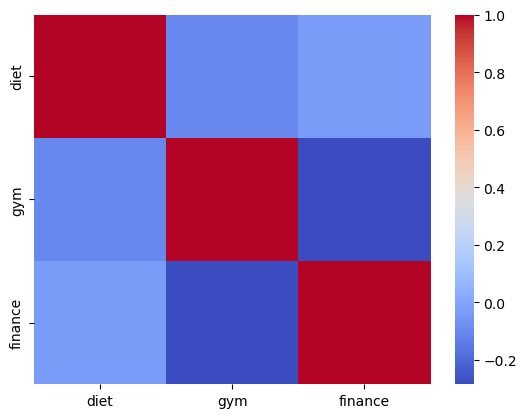

In [24]:
# Plot Correlation Matrix
sns.heatmap(df.corr(), cmap="coolwarm");

‘diet’ and ‘gym’ are negatively correlated! Remember that you have a seasonal and a trend component. From the correlation coefficient, ‘diet’ and ‘gym’ are negatively correlated:

    • trends components are negatively correlated.
    • seasonal components would positively correlated and their

The actual correlation coefficient is actually capturing both of those.

             diet       gym   finance
diet     1.000000  0.758707  0.373828
gym      0.758707  1.000000  0.301111
finance  0.373828  0.301111  1.000000


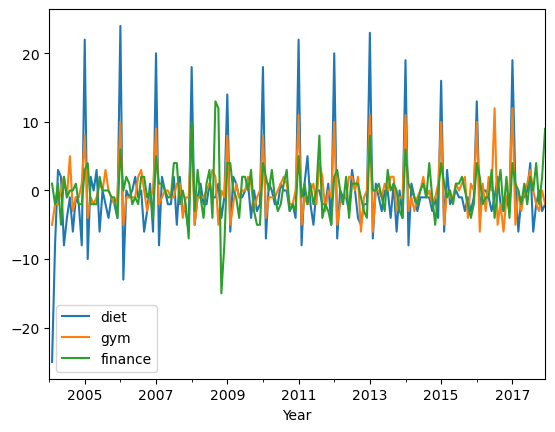

In [26]:
# Seasonal correlation: correlation of the first-order differences of these time series

df.diff().plot()
plt.xlabel('Year');
print(df.diff().corr())

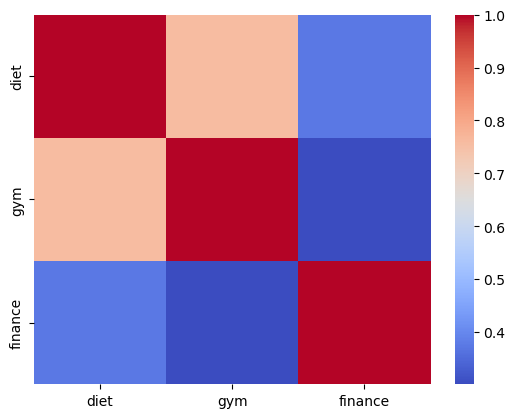

In [27]:
# Plot Correlation Matrix

sns.heatmap(df.diff().corr(), cmap="coolwarm");

#### Decomposing time serie in trend, seasonality and residuals

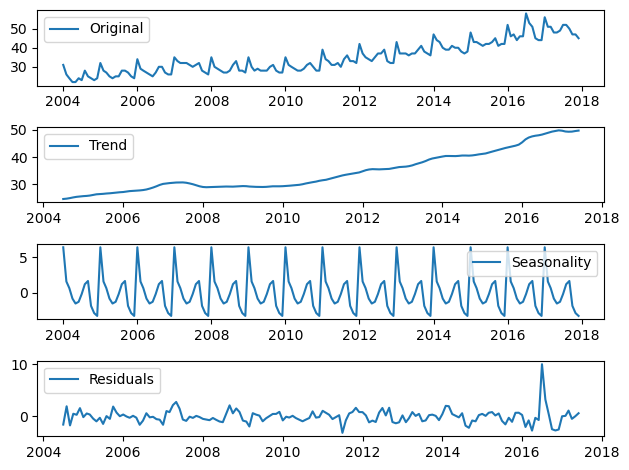

In [29]:
from statsmodels.tsa.seasonal import seasonal_decompose

x = gym                                # Assign the 'gym' data to x
x = x.astype(float)                    # Convert the data to float type
decomposition = seasonal_decompose(x)  # Decompose the time series into trend, seasonal, and residual components
trend = decomposition.trend            # Extract the trend component
seasonal = decomposition.seasonal      # Extract the seasonal component
residual = decomposition.resid         # Extract the residual component

plt.subplot(411)                       # Create the first subplot (1 row, 4 columns, first plot)
plt.plot(x, label='Original')          # Plot the original data
plt.legend(loc='best')                 # Display the legend in the best location
plt.subplot(412)                       # Create the second subplot (trend)
plt.plot(trend, label='Trend')         # Plot the trend component
plt.legend(loc='best')                 # Display the legend for the trend plot
plt.subplot(413)                       # Create the third subplot (seasonality)
plt.plot(seasonal, label='Seasonality')# Plot the seasonal component
plt.legend(loc='best')                 # Display the legend for the seasonal plot
plt.subplot(414)                       # Create the fourth subplot (residuals)
plt.plot(residual, label='Residuals')  # Plot the residual component
plt.legend(loc='best')                 # Display the legend for the residuals plot
plt.tight_layout()                     # Adjust the layout to prevent overlapping subplots

## Autocorrelation

A time series is periodic if it repeats itself at equally spaced intervals, say, every 12 months.
Autocorrelation Function (ACF): It is a measure of the correlation between the TS with a lagged
version of itself. For instance at lag 5, ACF would compare series at time instant t1. . . t2 with
series at instant t1-5. . . t2-5 (t1-5 and t2 being end points).

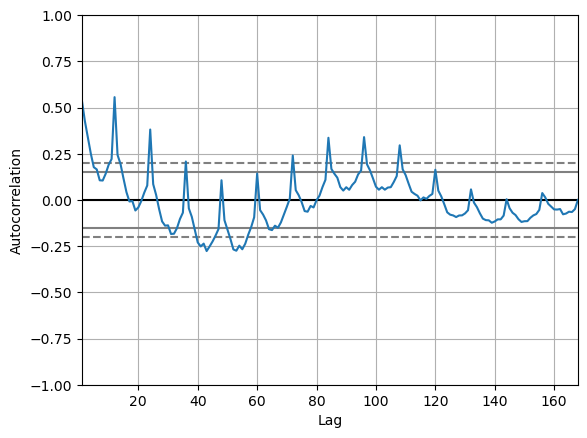

In [32]:
from pandas.plotting import autocorrelation_plot

x = df["diet"].astype(float)
autocorrelation_plot(x);

#### Compute Autocorrelation Function (ACF)

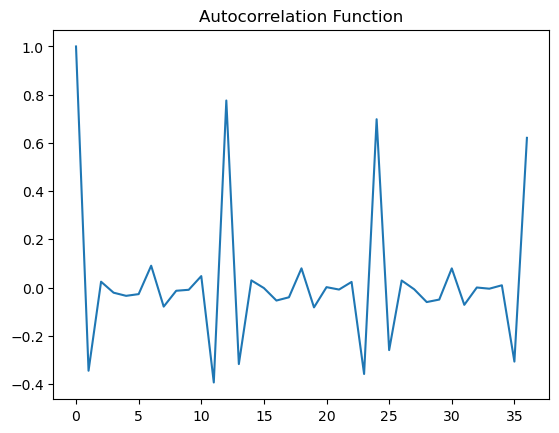

In [34]:
from statsmodels.tsa.stattools import acf

x_diff = x.diff().dropna()                 # Compute the difference of the series (first differences), drop the NaN resulting from the first difference
lag_acf = acf(x_diff, nlags=36)            # Calculate the ACF of the differenced data, up to 36 lags
plt.plot(lag_acf)                          # Plot the autocorrelation function for the differenced data
plt.title('Autocorrelation Function');     # Add a title to the plot

ACF peaks every 12 months: Time series is correlated with itself shifted by 12 months.

## Time Series Forecasting with Python using Autoregressive Moving Average (ARMA) models

ARMA models are often used to forecast a time series. These models combine autoregressive
and moving average models. In moving average models, we assume that a variable is the sum
of the mean of the time series and a linear combination of noise components.


The autoregressive and moving average models can have different orders. In general, we can
define an ARMA model with p autoregressive terms and q moving average terms as follows:

$$
x_t = \sum_{i=1}^{p} a_i x_{t-i} + \sum_{i=1}^{q} b_i \epsilon_{t-i} + \epsilon_t
$$


### Choosing p and q

Plot the partial autocorrelation functions for an estimate of p, and likewise using the autocorrelation functions for an estimate of q.
    
Partial Autocorrelation Function (PACF): This measures the correlation between the TS with a
lagged version of itself but after eliminating the variations already explained by the intervening
comparisons. Eg at lag 5, it will check the correlation but remove the effects already explained
by lags 1 to 4.

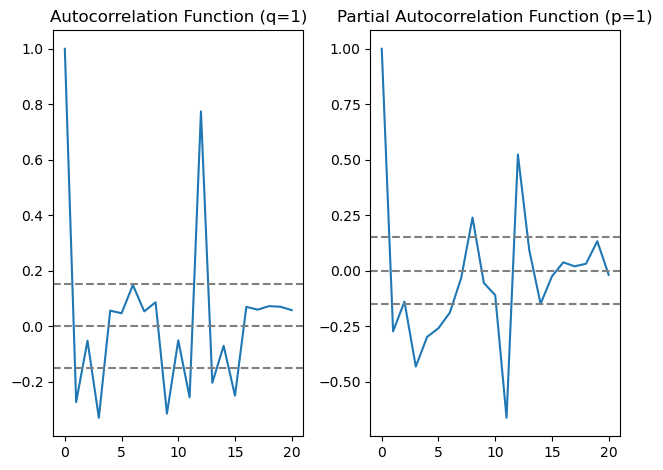

In [40]:
from statsmodels.tsa.stattools import acf, pacf

x = df["gym"].astype(float)  # Convert the 'gym' column to float type
x_diff = x.diff().dropna()   # Compute the first difference of the series and drop the NA value

# ACF and PACF plots:
lag_acf = acf(x_diff, nlags=20)                  # Compute the autocorrelation function for lags up to 20
lag_pacf = pacf(x_diff, nlags=20, method='ols')  # Compute the partial autocorrelation function for lags up to 20

# Plot ACF:
plt.subplot(121)                                                         # Create subplot 1 of 2
plt.plot(lag_acf)                                                        # Plot the autocorrelation function
plt.axhline(y=0, linestyle='--', color='gray')                           # Add horizontal line at y=0
plt.axhline(y=-1.96/np.sqrt(len(x_diff)), linestyle='--', color='gray')  # Add lower confidence interval line
plt.axhline(y=1.96/np.sqrt(len(x_diff)), linestyle='--', color='gray')   # Add upper confidence interval line
plt.title('Autocorrelation Function (q=1)')                              # Set the title of the plot

# Plot PACF:
plt.subplot(122)                                                         # Create subplot 2 of 2
plt.plot(lag_pacf)                                                       # Plot the partial autocorrelation function
plt.axhline(y=0, linestyle='--', color='gray')                           # Add horizontal line at y=0
plt.axhline(y=-1.96/np.sqrt(len(x_diff)), linestyle='--', color='gray')  # Add lower confidence interval line
plt.axhline(y=1.96/np.sqrt(len(x_diff)), linestyle='--', color='gray')   # Add upper confidence interval line
plt.title('Partial Autocorrelation Function (p=1)')                      # Set the title of the plot
plt.tight_layout()                                                       # Adjust subplots to fit into the figure area

In this plot, the two dotted lines on either sides of 0 are the confidence interevals. These can be
used to determine the p and q values as:

    • p: The lag value where the PACF chart crosses the upper confidence interval for the first time, in this case p=1.

	• q: The lag value where the ACF chart crosses the upper confidence interval for the first time, in this case q=1.

### Fit ARMA model with statsmodels
1. Define the model by calling `ARMA()` and passing in the p and q parameters.
2. The model is prepared on the training data by calling the `fit()` function.
3. Predictions can be made by calling the `predict()` function and specifying the index of the
time or times to be predicted.

                               SARIMAX Results                                
Dep. Variable:                    gym   No. Observations:                  168
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -436.852
Date:                Tue, 17 Sep 2024   AIC                            881.704
Time:                        08:30:24   BIC                            894.200
Sample:                    01-01-2004   HQIC                           886.776
                         - 12-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         36.4287     14.339      2.541      0.011       8.325      64.532
ar.L1          0.9967      0.007    152.509      0.000       0.984       1.009
ma.L1         -0.7494      0.065    -11.568      0.0

C:\Users\lsoares\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\lsoares\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\lsoares\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


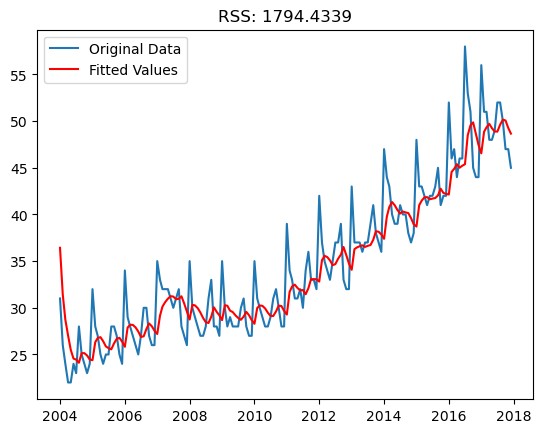

In [43]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Fit the ARIMA model (using p=1, d=0, q=1)
model = ARIMA(x, order=(1, 0, 1)).fit()  # Note: d=0 for ARMA, since ARMA does not use differencing

print(model.summary())  # Print the model summary

# Plot the original data and the fitted values
plt.plot(x, label='Original Data')                                # Plot original data
plt.plot(model.fittedvalues, color='red', label='Fitted Values')  # Plot fitted values
plt.title('RSS: %.4f' % sum((model.fittedvalues - x) ** 2))       # Display RSS
plt.legend()  # Show legend
plt.show()    # Display the plot